2do Parcial - Dataset 1
Baldiviezo Cruz Dereck Fernando

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import drive

#Cargar el dataset

Este dataset contiene mediciones tomadas en un punto de monitoreo (Coquette Point) del río Johnstone, Australia. Las mediciones están asociadas a variables químicas y ambientales que ayudan a evaluar la calidad del agua.

Columnas más relevantes:

Conductivity: Medida de la conductividad eléctrica del agua (a mayor valor, más sales disueltas).

NO3: Concentración de nitrato (fertilizantes, contaminación).

Temp: Temperatura del agua (°C).

Turbidity: Turbidez del agua (sólidos suspendidos).

Dayofweek: Día de la semana en que se registró la medición (0=Lunes, 6=Domingo).

Month: Mes en el que se hizo la medición (1 a 12)

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# Cargar el nuevo dataset de calidad del agua
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Johnstone_river_coquette_point_joined.csv')

# Ver las primeras filas
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Timestamp,Conductivity,NO3,Temp,Turbidity,Dayofweek,Month
0,2017-05-11T14:00:00,13502.10,NaN,NaN,12.79,3,5
1,2017-05-11T15:00:00,10304.00,NaN,NaN,11.93,3,5
2,2017-05-11T16:00:00,5588.08,NaN,NaN,10.34,3,5
3,2017-05-11T17:00:00,13937.00,NaN,NaN,24.02,3,5
4,2017-05-11T18:00:00,44761.40,NaN,NaN,18.46,3,5


# Selección y limpieza de columnas

Selecciona las columnas más útiles para estudiar patrones en la calidad del agua.

Elimina filas con valores faltantes.

Toma un subconjunto de hasta 20,000 registros para que sea más eficiente el análisis.



In [ ]:
# Columnas relevantes para clustering
cols = ['Conductivity', 'NO3', 'Temp', 'Turbidity', 'Dayofweek', 'Month']

# Eliminar nulos y tomar máximo 20,000 registros
data = df[cols].dropna().iloc[:20000]


#Normalización de datos

Normaliza los datos para que todas las variables tengan la misma escala (media 0, desviación estándar 1).

Esto es crucial para K-Means, ya que usa distancias: sin escalamiento, variables como "Conductivity" (que puede tener valores grandes) dominarían sobre otras.

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


#Determinar el número óptimo de clusters

#a. Método del codo

Calcula la inercia para diferentes valores de k (número de clusters).

La inercia mide qué tan cerca están los puntos de su centro de cluster.

Se busca el “codo” en la curva, que es el valor de k donde agregar más clusters deja de mejorar significativamente el modelo.

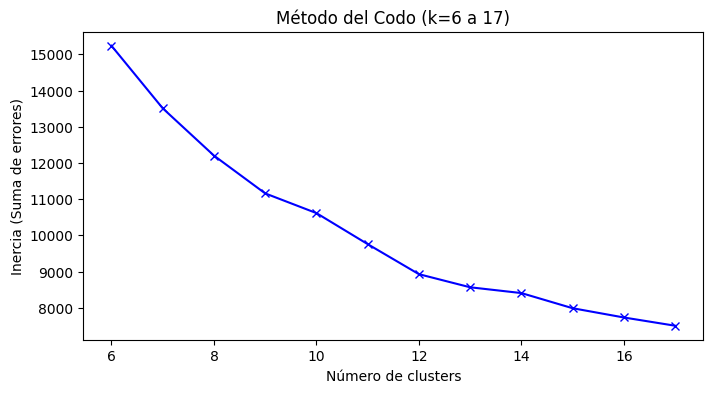

In [ ]:
inertia = []
K = range(6, 18)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (Suma de errores)')
plt.title('Método del Codo (k=6 a 17)')
plt.show()


#b. Coeficiente de Silhouette
Calcula el Silhouette Score para ver qué tan bien definidos están los clusters.

Almacena los modelos para los k más relevantes (2 a 6) para análisis posteriores.

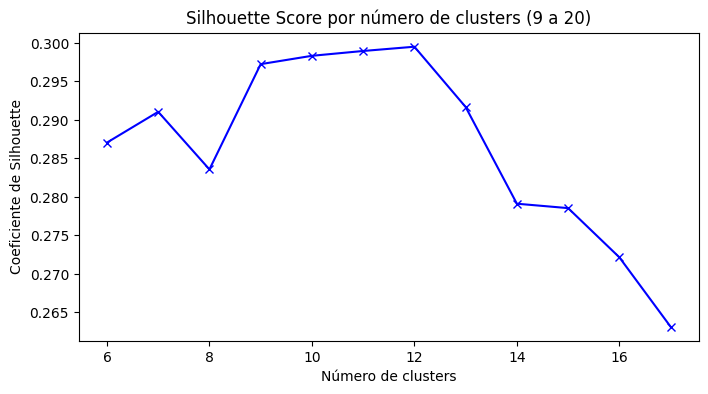

In [ ]:
silhouette_scores = []
kmeans_per_k = {}

for k in range(6, 18):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, preds)
    silhouette_scores.append(score)

    if k in (8, 9, 10, 11, 12, 13):
        kmeans_per_k[k] = {
            'model': kmeans,
            'labels': preds
        }

plt.figure(figsize=(8, 4))
plt.plot(range(6, 18), silhouette_scores, 'bx-')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Silhouette Score por número de clusters (9 a 20)')
plt.show()


# Gráfico detallado de silhouette por cluster

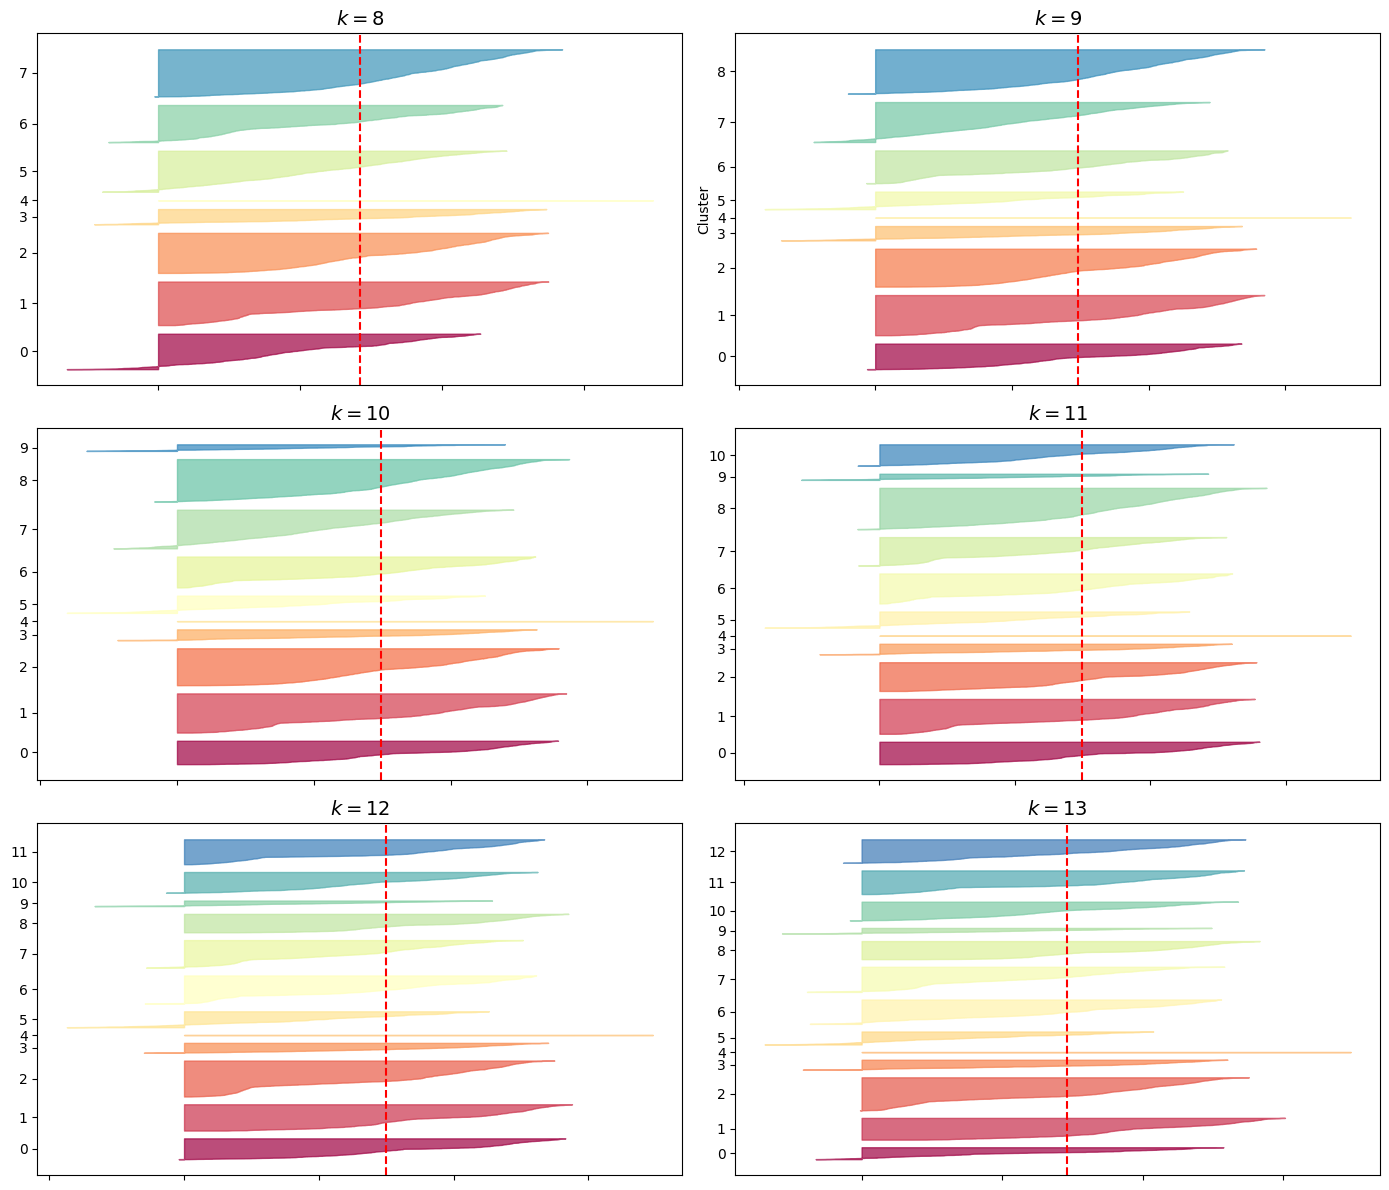

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import numpy as np

plt.figure(figsize=(14, 12))
keys = (8, 9, 10, 11, 12, 13)
silhouette_scores_subset = []

for idx, k in enumerate(keys):
    y_pred = kmeans_per_k[k]['labels']
    score = silhouette_score(data_scaled, y_pred)
    silhouette_scores_subset.append(score)

    plt.subplot(3, 2, idx + 1)

    silhouette_vals = silhouette_samples(data_scaled, y_pred)
    padding = len(data_scaled) // 30
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_vals[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if k in (9, 15):
        plt.ylabel("Cluster")
    if k in (15, 20):
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores_subset[idx], color="red", linestyle="--")
    plt.title(f"$k={k}$", fontsize=14)

plt.tight_layout()
plt.show()

# Asignación final de clusters

In [ ]:
kmeans = KMeans(n_clusters=12, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Añadir etiquetas al DataFrame original
data['Cluster'] = clusters


# Visualización final
Crea un gráfico de pares de variables (pairplot) para ver cómo se relacionan y cómo se separan los clusters en el espacio de variables.

Colorea por cluster.

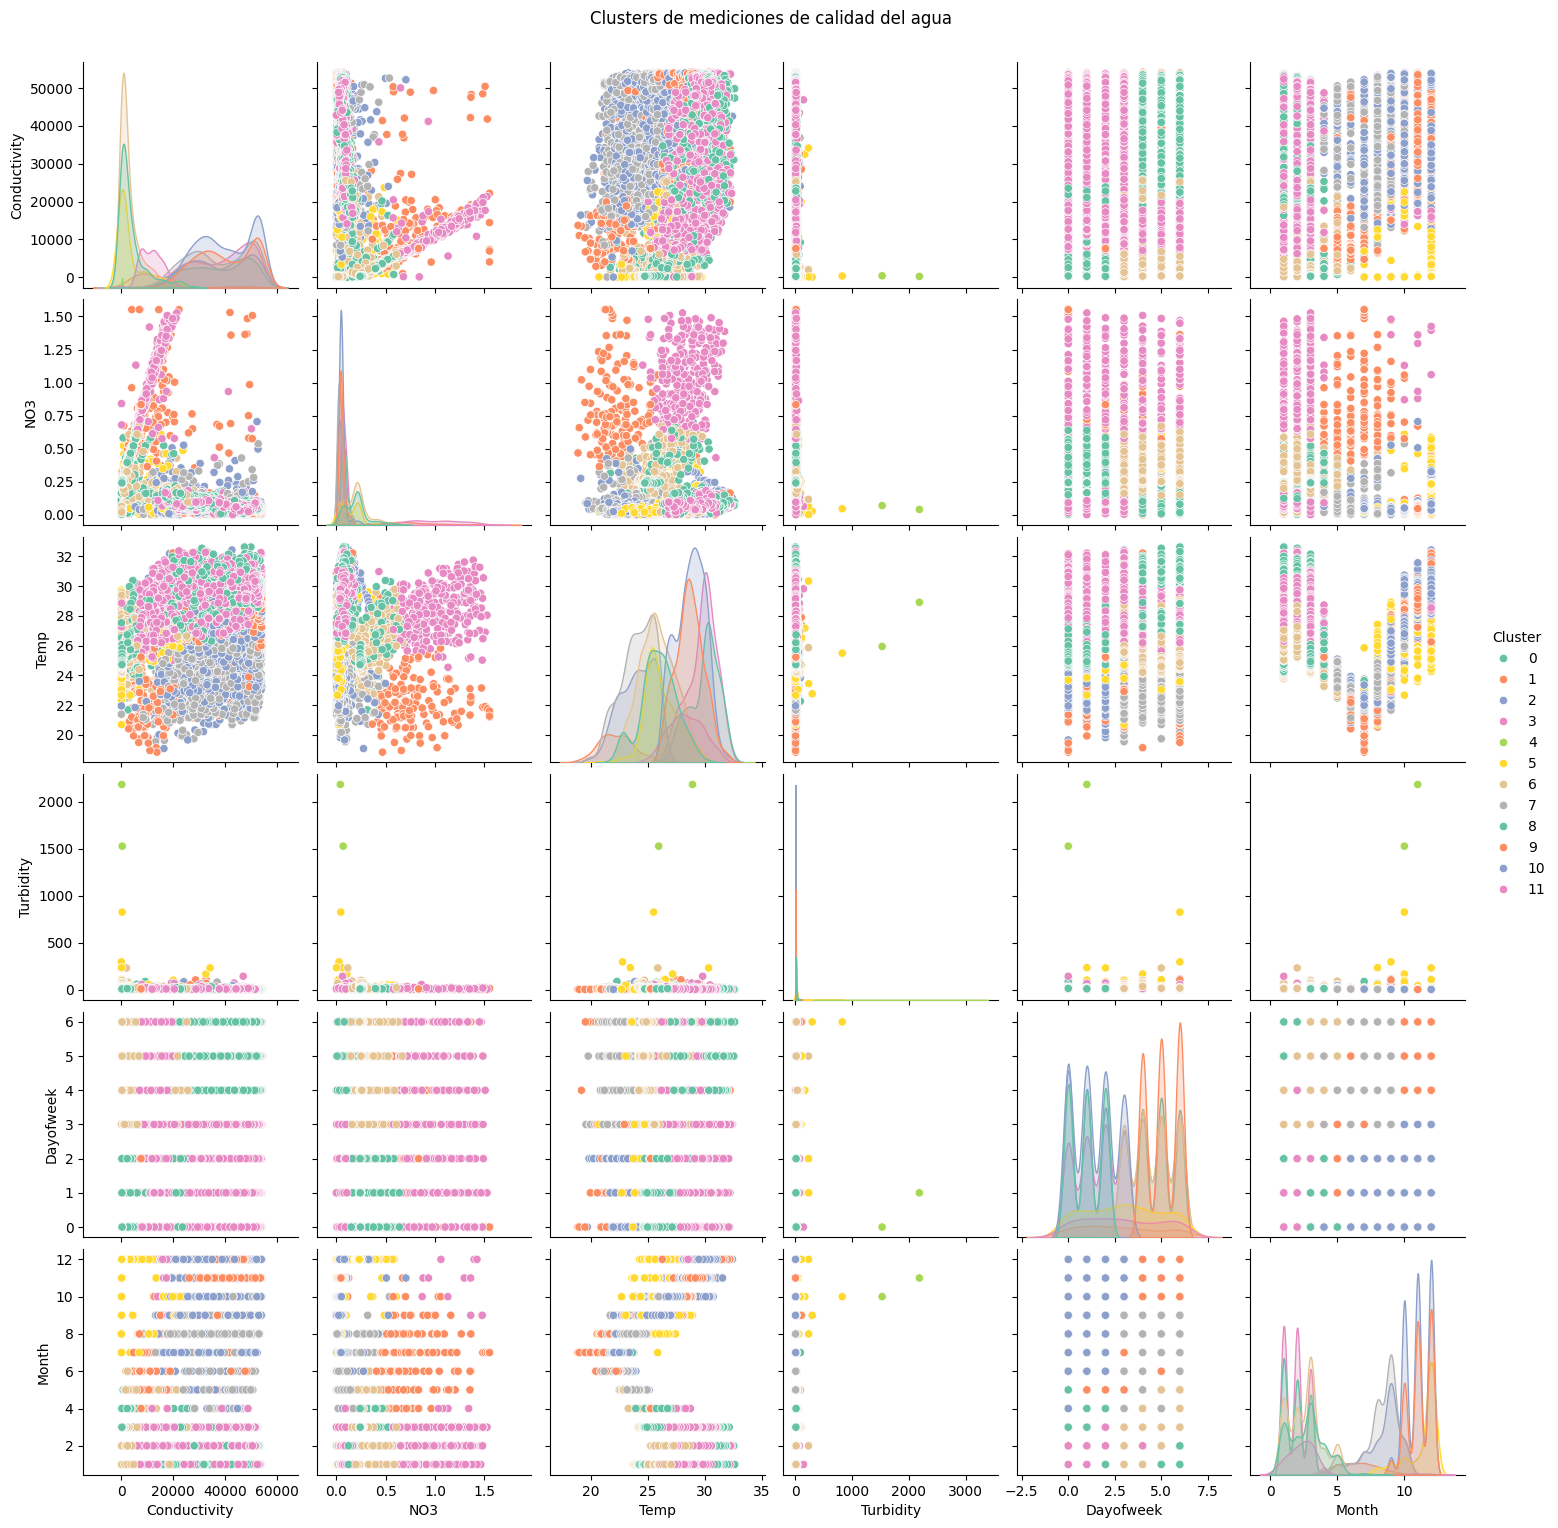

In [ ]:
import seaborn as sns

sns.pairplot(data, hue='Cluster', palette='Set2')
plt.suptitle("Clusters de mediciones de calidad del agua", y=1.02)
plt.show()
